## Cleaning

In [70]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics, preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

Read in player data

In [71]:
playerDf = pd.read_csv('trainingData/CollegeBasketballPlayers2009-2021.csv', low_memory=False)

#initial dropping of inconsistant data for player data 
playerDf = playerDf.rename(columns = {'Unnamed: 64' : 'role_position'})
playerDf = playerDf.drop('Unnamed: 65', axis=1) # Has no meaning in the dataset
playerDf = playerDf.drop('ht', axis=1) # Temporarily excluding this column due to inconsistent date formats and other values
playerDf = playerDf.drop('num', axis=1) # It might denote a player's choice or position but with significant variation in meaning.
playerDf = playerDf.drop('type', axis=1) # Column has 1 unique value
playerDf= playerDf.drop('pid', axis=1) # catigorical, not needed 
playerDf= playerDf.drop('yr', axis=1) # catigorical, not needed 

playerDf.shape

(61061, 60)

Display columns with over 60% nulls and drop them

In [73]:
# Count and remove columns with over 60% nan values from players
total = len(playerDf)
for column in playerDf.columns:
    count = playerDf[column].isna().sum()
    percent= (count/ total) * 100
    if (percent>=60):
        print(f"Player  DF: Column '{column}':", f"Number of NaN: {count}", f"Percentage: {percent:.2f}%")

Player  DF: Column 'Rec Rank': Number of NaN: 42591 Percentage: 69.75%
Player  DF: Column 'pick': Number of NaN: 59626 Percentage: 97.65%


In [74]:
#Drop all the over 60% cols from the player. Dont drop pick, nan recorded as not drafted, need for predictions filling in later
playerDf = playerDf.drop('Rec Rank', axis=1) 

In [76]:
player_corr_matrix = playerDf.corr(numeric_only=True)

Findand remove redundant data 

In [79]:
# player_corr_matrix=playerDf.corr()

# # find any corrilation >.9 to determine redundant features 
# threshold = 0.9  


# # Iterate through the correlation matrix and print highly correlated pairs
# for i in range(len(player_corr_matrix.columns)):
#     for j in range(i + 1, len(player_corr_matrix.columns)):  # Added a closing parenthesis here
#         if abs(player_corr_matrix.iloc[i, j]) >= threshold:
#             print(f"Player: {player_corr_matrix.columns[i]} and {player_corr_matrix.columns[j]}: {player_corr_matrix.iloc[i, j]:.2f}")



correlation_threshold = 0.9

# Create positive correlation matrix
corr_df = playerDf.corr(numeric_only=True).abs()

# Create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)

# Find columns that meet threshold
features_to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.90)]
print(features_to_drop)

['Min_per', 'Ortg', 'eFG', 'FTM', 'twoPM', 'twoPA', 'TPM', 'rimmade', 'midmade', 'dunksmade', 'drtg', 'dporpag', 'stops', 'gbpm', 'mp', 'dreb']


In [80]:
# # remove redundancy in player 
# playerDf= playerDf.drop('rimmade', axis=1) 
# playerDf= playerDf.drop('rimmade+rimmiss', axis=1) 
# playerDf= playerDf.drop('Ortg', axis=1) 
# playerDf= playerDf.drop('Min_per', axis=1) 
# playerDf= playerDf.drop('eFG', axis=1) 
# playerDf= playerDf.drop('drtg', axis=1)
# playerDf= playerDf.drop('stops', axis=1)
# playerDf= playerDf.drop('gbpm', axis=1)
# playerDf= playerDf.drop('dreb', axis=1)
# playerDf= playerDf.drop('midmade+midmiss', axis=1)
# playerDf= playerDf.drop('dunksmiss+dunksmade', axis=1)
# playerDf= playerDf.drop('twoPA', axis=1)
# playerDf= playerDf.drop('TPA', axis=1)
# playerDf= playerDf.drop('FTA', axis=1)

# Remove the highly correlated features from the DataFrame
playerDf = playerDf.drop(columns=features_to_drop, axis=1)

# Display the new shape of the DataFrame
print("Shape of the DataFrame after removing highly correlated features:", playerDf.shape)

Shape of the DataFrame after removing highly correlated features: (61061, 43)


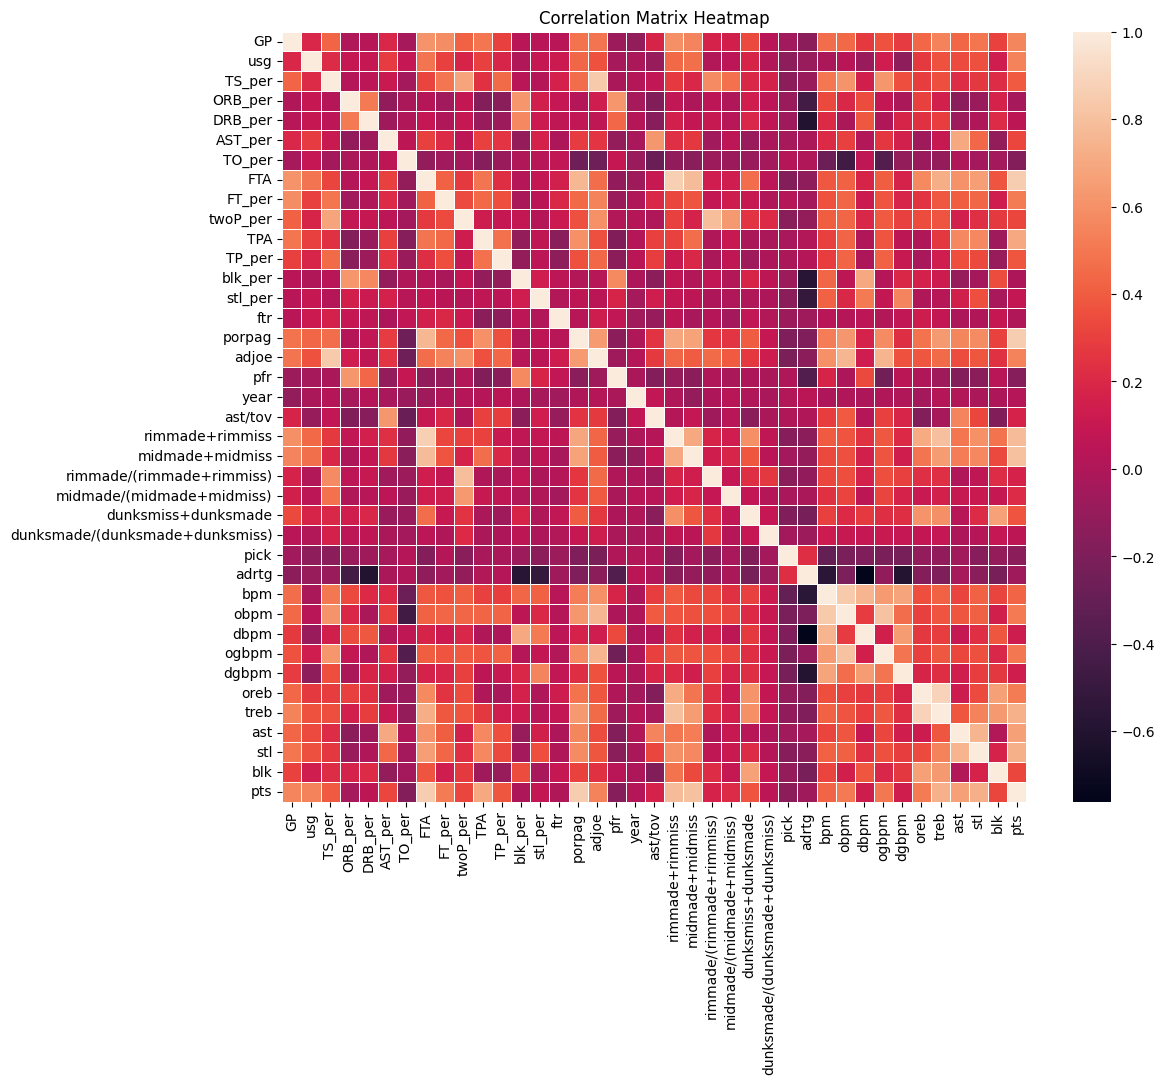

In [82]:
player_corr_matrix = playerDf.corr(numeric_only=True)

# Create a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(player_corr_matrix, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [89]:
categorical_columns = ['player_name', 'team', 'role_position']  

# Function to calculate weighted average
def weighted_avg(group):
    categorical_data = group.loc[group.index[-1], categorical_columns]
    data_to_ave = group.drop(columns=categorical_columns).mean(numeric_only=True)

    if any(group['pick'] == 1):
        group['pick'] = 1  
    return pd.concat([categorical_data, data_to_ave])

# Group by player name and team, then apply weighted average
playerDf['player_name'] = playerDf['player_name'].str.lower()
player_grouped = playerDf.groupby(['player_name', 'team']).apply(weighted_avg)

In [90]:
player_grouped.head()

print(player_grouped['year'])

player_name      team         
a'torey everett  Tennessee St.    2017.0
a'torri shine    Grambling St.    2014.5
a'uston calhoun  Bowling Green    2011.5
a.c. reid        Liberty          2016.0
                 Tennessee St.    2018.0
                                   ...  
zygis sestokas   Hofstra          2009.0
zylan cheatham   Arizona St.      2019.0
                 San Diego St.    2016.5
zyon dobbs       James Madison    2020.0
zyon pullin      UC Riverside     2020.5
Name: year, Length: 30200, dtype: float64


KNN to fill in all NAN values

In [91]:
#if drafted, change to 1 
playerDf.loc[playerDf["pick"] > 0, "pick"] = 1
#not drafted was nan, replace with 0 
playerDf.loc[playerDf["pick"] != 1, "pick"] = 0

KNN to fill in all NAN values

In [92]:
team_label_encoder = LabelEncoder()
playerDf['team'] = team_label_encoder.fit_transform(playerDf['team'])

conf_label_encoder = LabelEncoder()
playerDf['conf'] = conf_label_encoder.fit_transform(playerDf['conf'])

role_position_label_encoder = LabelEncoder()
playerDf['role_position'] = role_position_label_encoder.fit_transform(playerDf['role_position'])

player_name_label_encoder = LabelEncoder()
playerDf['player_name'] = player_name_label_encoder.fit_transform(playerDf['player_name'])

In [93]:
imputer = KNNImputer(n_neighbors=10)
imputed_numeric = imputer.fit_transform(playerDf.select_dtypes(include=np.number))
dfBasketballTraining_filled = pd.DataFrame(imputed_numeric, columns=playerDf.select_dtypes(include=np.number).columns)
string_columns = playerDf.select_dtypes(include='object').columns
imputed_data = pd.concat([playerDf[string_columns], dfBasketballTraining_filled], axis=1)

Split into training and test 

Only using players who were drafted as training data, removing the noise of players who were not drafted.

In [94]:
# trainDf=playerDf.loc[playerDf['pick'] >= 1]
# trainDf = trainDf.loc[trainDf['year'] < 2021]
trainDf=playerDf.loc[playerDf['year'] <2017]
testDf= playerDf.loc[playerDf['year'] >= 2021]

Finding outliers and smoothing the data 

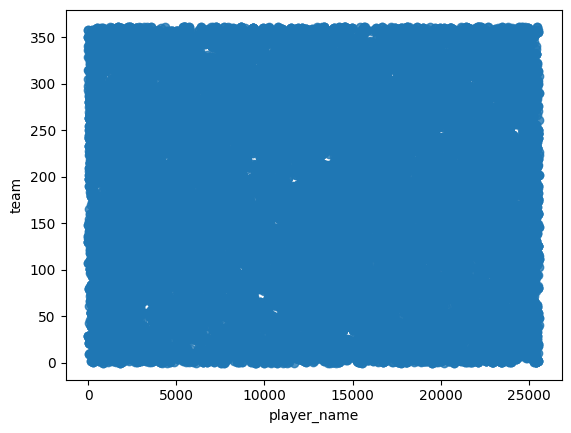

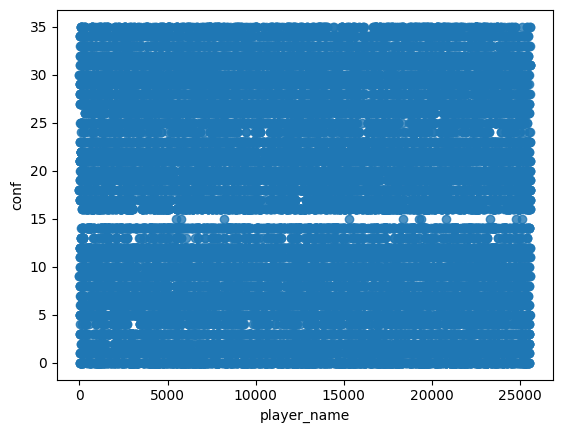

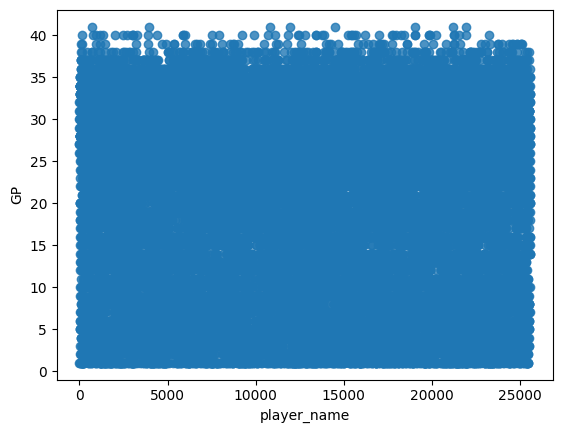

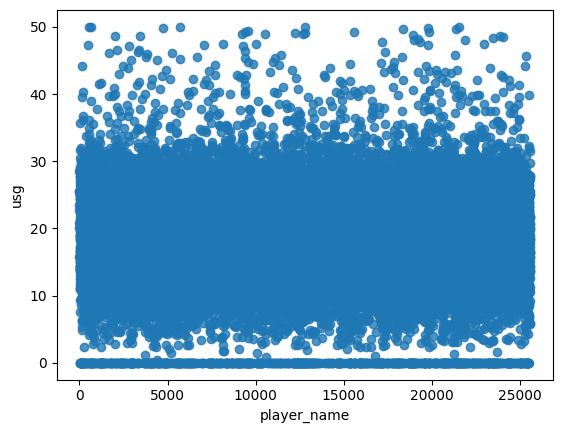

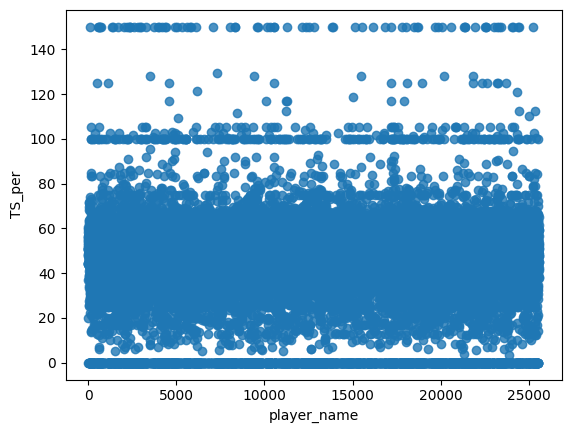

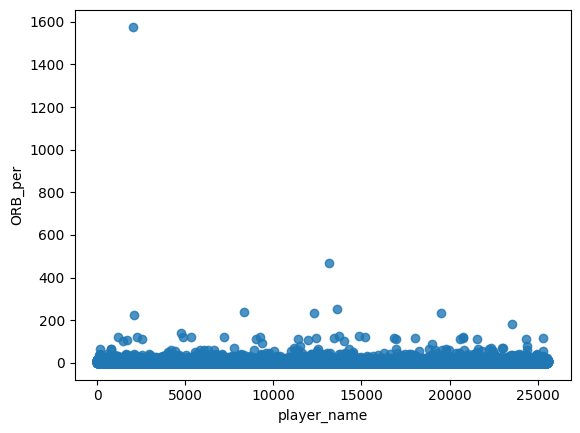

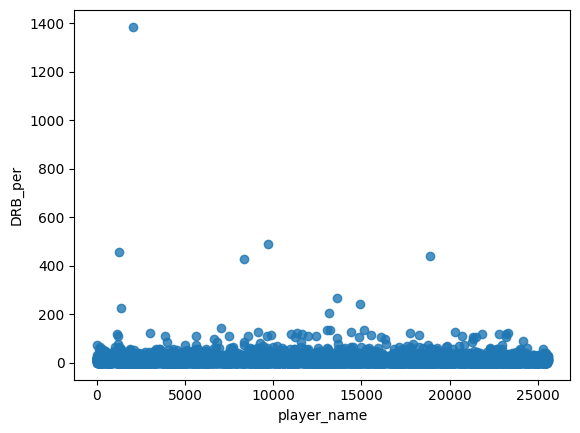

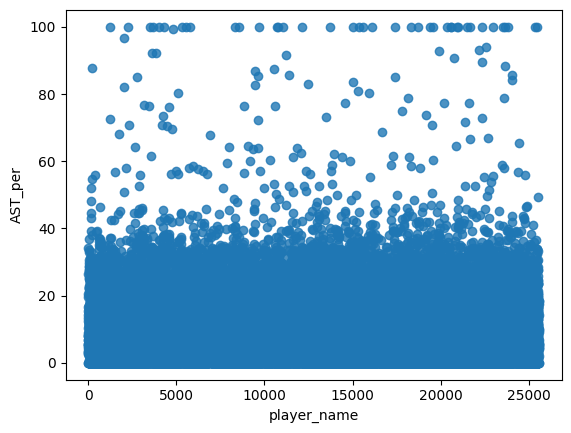

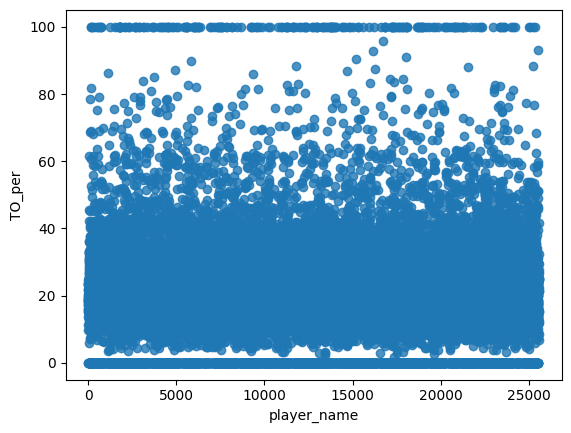

KeyboardInterrupt: 

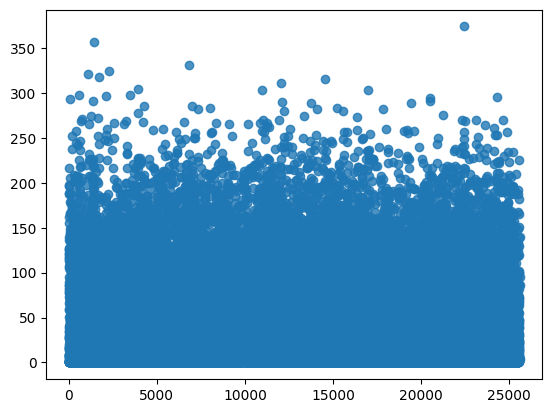

In [95]:
for j in range(1, len(trainDf.columns)):
    sns.regplot(x=trainDf.columns[0], y=trainDf.columns[j], data=trainDf)
    plt.show()

In [ ]:
# binning by means
def bin_mean(data, bin_size):
    binned_data = []
    for i in range(0, len(data), bin_size):
        mean_value = np.mean(data[i:i+bin_size])
        size = bin_size if i + bin_size < len(data) else len(data) - i
        binned_data.extend([mean_value] * size)
    return np.array(binned_data)

#binning with medians
def bin_median(data, bin_size):
    binned_data = []
    for i in range(0, len(data), bin_size):
        median_value = np.median(data[i:i+bin_size])
        size = bin_size if i + bin_size < len(data) else len(data) - i
        binned_data.extend([median_value] * size)
    return np.array(binned_data)

data = trainDf

binned_df = data.copy()

#Sort df 
#sorted_df = binned_df.sort_values(by=['team'])

# List of columns to be smoothed
columns_to_smooth = ['usg', 'TS_per', 'ORB_per', 'DRB_per', 'AST_per', 'TO_per', 'FTM', 'FT_per', 'twoPM', 'twoP_per', 'TPM', 'TP_per', 'blk_per', 'stl_per', 'ftr_player', 'porpag', 'adjoe_player', 'pfr', 'ast/tov', 'midmade', 'rimmade/(rimmade+rimmiss)', 'midmade/(midmade+midmiss)', 'dunksmade', 'dunksmade/(dunksmade+dunksmiss)', 'adrtg', 'dporpag', 'bpm', 'obpm', 'dbpm', 'mp', 'ogbpm', 'dgbpm', 'oreb', 'treb', 'ast', 'stl', 'blk', 'pts', 'g', 'w', 'adjoe_team', 'adjde', 'barthag', 'efg_o', 'efg_d', 'tor', 'tord', 'orb', 'drb', 'ftr_team', 'ftrd', '2p_o', '3p_o', '3p_d', 'adj_t']
#Need to update number of bins 
#This uses Sturges’ Formula: 1+log2(n)
num_bins = 17; 

#smooth columns
for col in columns_to_smooth:
    if col in data.columns: 
    #Change to sorted_df for sorting 
    #Change to bin_mean if needed
        binned_df[col] = bin_median(binned_df[col].values, num_bins) 
trainDf=binned_df
trainDf

player_name   team  conf    GP    usg  TS_per  ORB_per  DRB_per  \
0           6413.0  269.0  27.0  26.0  16.60  53.690     4.80    11.70   
1          20046.0  331.0  33.0  34.0  16.60  53.690     4.80    11.70   
2          12256.0  274.0   7.0  27.0  16.60  53.690     4.80    11.70   
3          18148.0  233.0  34.0  30.0  16.60  53.690     4.80    11.70   
4           1314.0  230.0  10.0  33.0  16.60  53.690     4.80    11.70   
...            ...    ...   ...   ...    ...     ...      ...      ...   
37167       4534.0  243.0   9.0  25.0  22.25  48.265     5.35    15.35   
37168       5373.0  155.0  12.0  13.0  22.25  48.265     5.35    15.35   
37169       4041.0  355.0   5.0  31.0  22.25  48.265     5.35    15.35   
37170      20805.0  240.0   7.0  14.0  22.25  48.265     5.35    15.35   
37171      11982.0  206.0  19.0  29.0  22.25  48.265     5.35    15.35   

       AST_per  TO_per  ...       mp     ogbpm     dgbpm    oreb     treb  \
0        11.90   19.80  ...  23.8235 -0.342775 -0.668318  0.8000  3.16670   
1        11.90   19.80  ...  23.8235 -0.342775 -0.668318  0.8000  3.16670   
2        11.90   19.80  ...  23.8235 -0.342775 -0.668318  0.8000  3.16670   
3        11.90   19.80  ...  23.8235 -0.342775 -0.668318  0.8000  3.16670   
4        11.90   19.80  ...  23.8235 -0.342775 -0.668318  0.8000  3.16670   
...        ...     ...  ...      ...       ...       ...     ...      ...   
37167     7.75   18.05  ...  12.2117 -1.735270 -0.634634  0.5279  2.01615   
37168     7.75   18.05  ...  12.2117 -1.735270 -0.634634  0.5279  2.01615   
37169     7.75   18.05  ...  12.2117 -1.735270 -0.634634  0.5279  2.01615   
37170     7.75   18.05  ...  12.2117 -1.735270 -0.634634  0.5279  2.01615   
37171     7.75   18.05  ...  12.2117 -1.735270 -0.634634  0.5279  2.01615   

           ast      stl      blk      pts  role_position  
0      1.19230  0.45450  0.23530  6.47060            8.0  
1      1.19230  0.45450  0.23530  6.47060            8.0  
2      1.19230  0.45450  0.23530  6.47060            8.0  
3      1.19230  0.45450  0.23530  6.47060            8.0  
4      1.19230  0.45450  0.23530  6.47060            8.0  
...        ...      ...      ...      ...            ...  
37167  0.49195  0.26635  0.22725  4.85385            5.0  
37168  0.49195  0.26635  0.22725  4.85385            4.0  
37169  0.49195  0.26635  0.22725  4.85385            2.0  
37170  0.49195  0.26635  0.22725  4.85385            2.0  
37171  0.49195  0.26635  0.22725  4.85385            6.0  

[37172 rows x 45 columns]

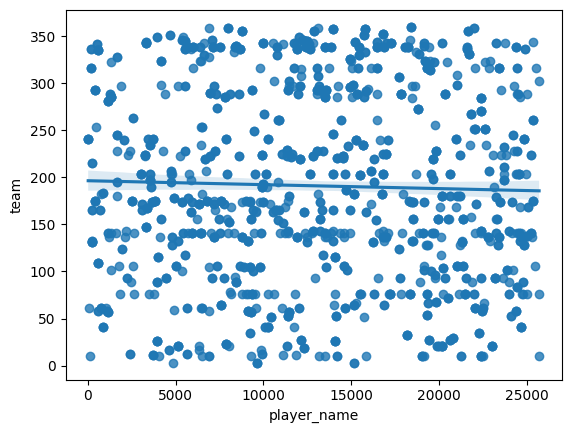

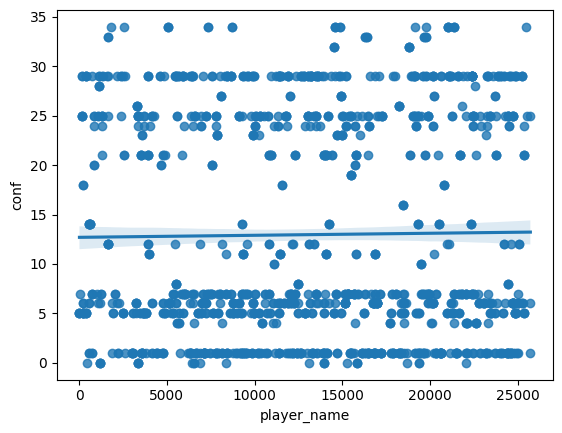

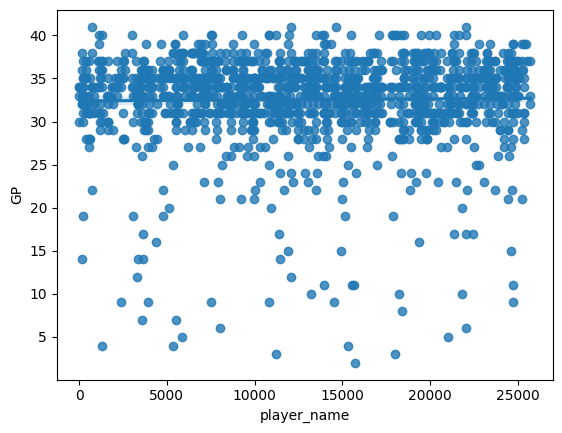

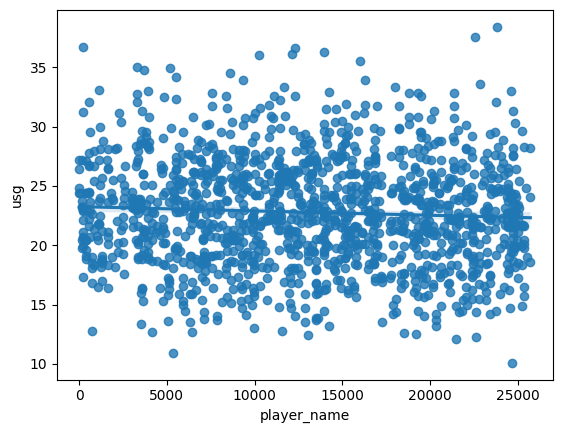

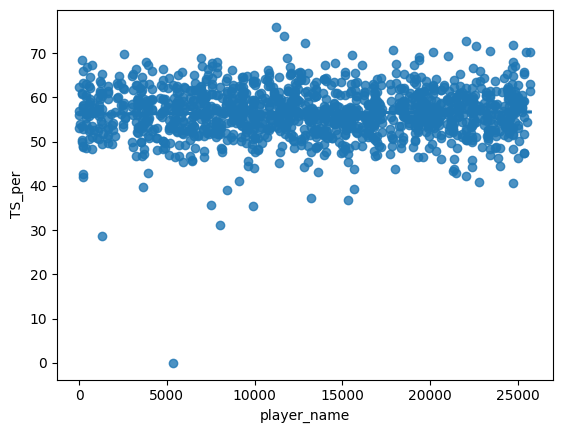

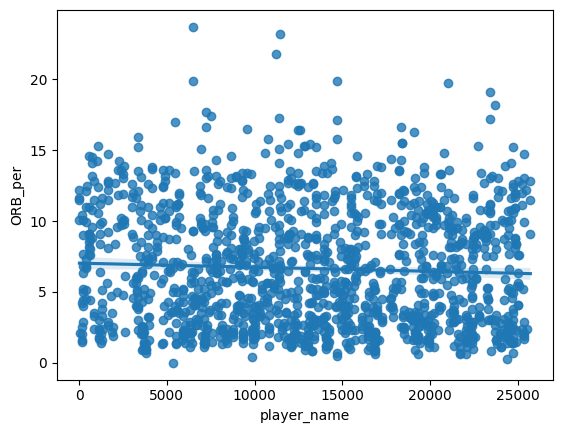

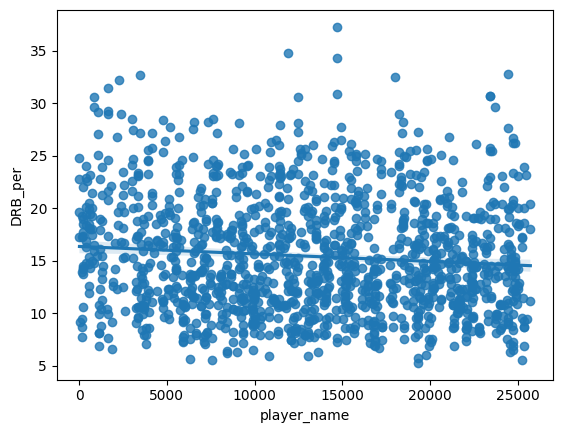

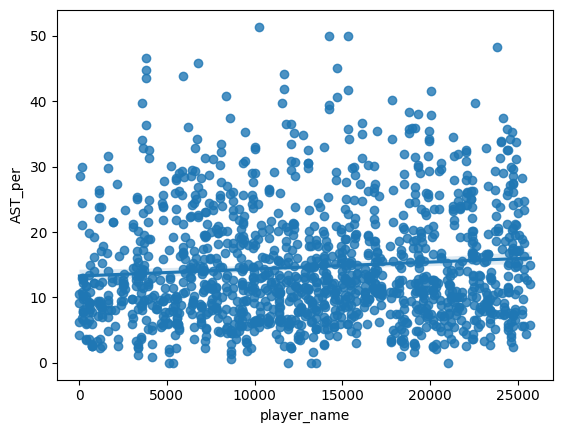

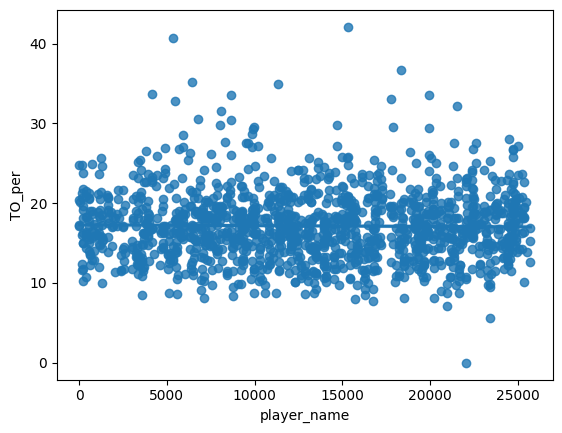

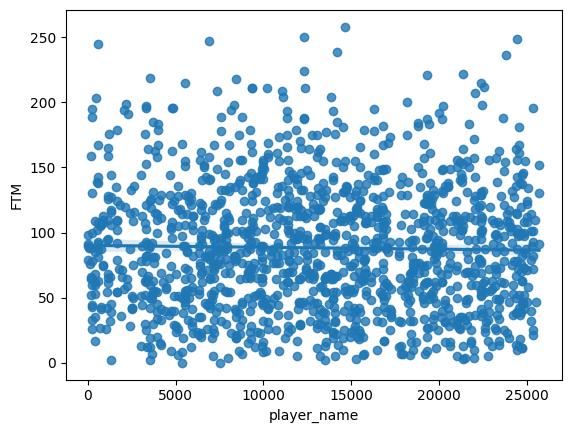

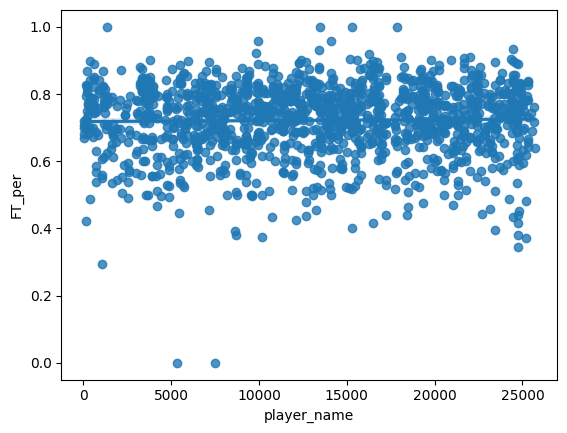

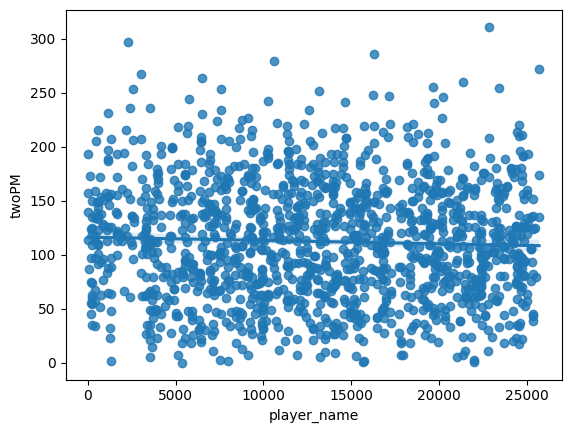

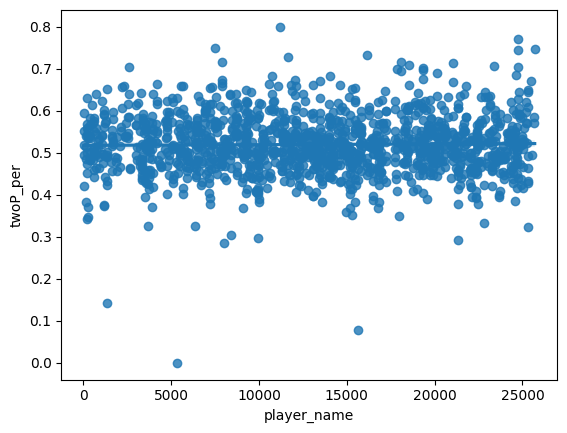

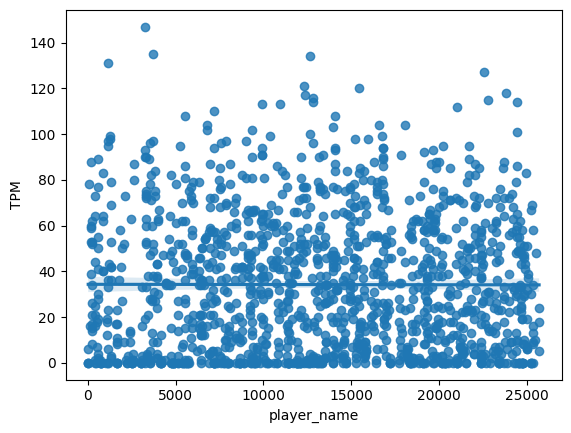

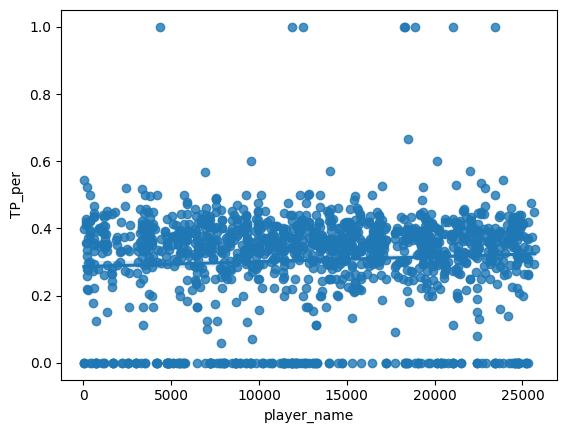

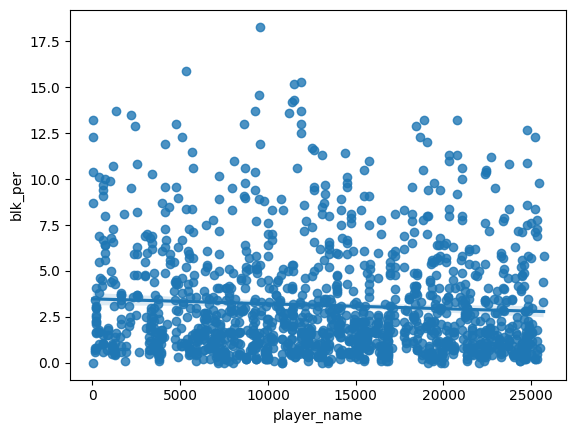

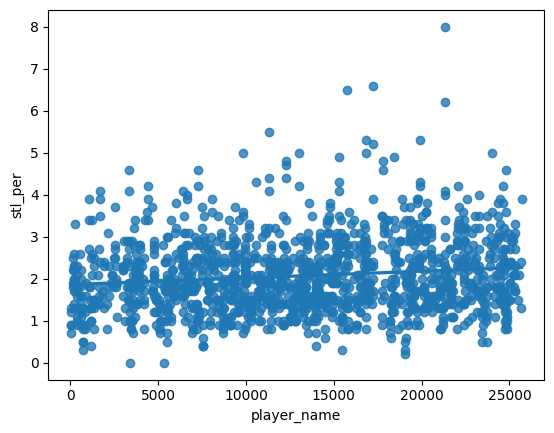

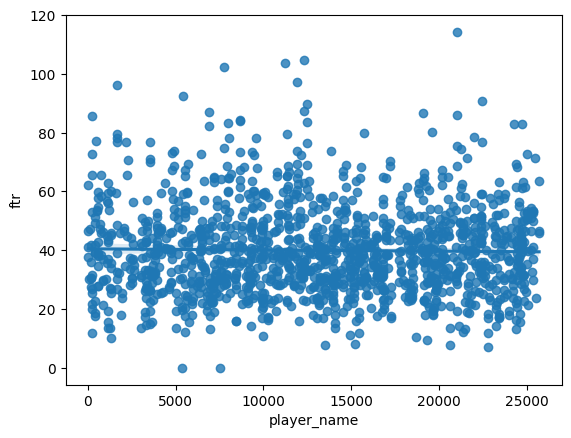

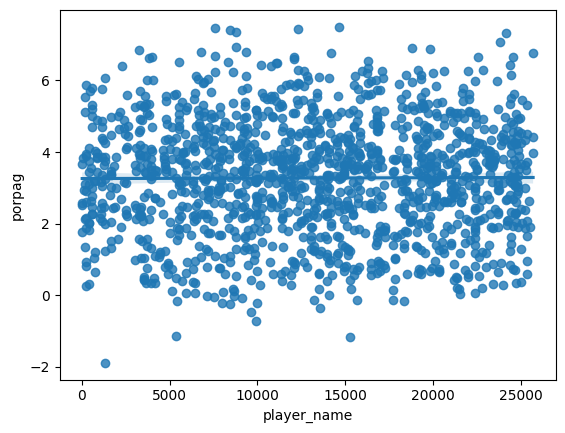

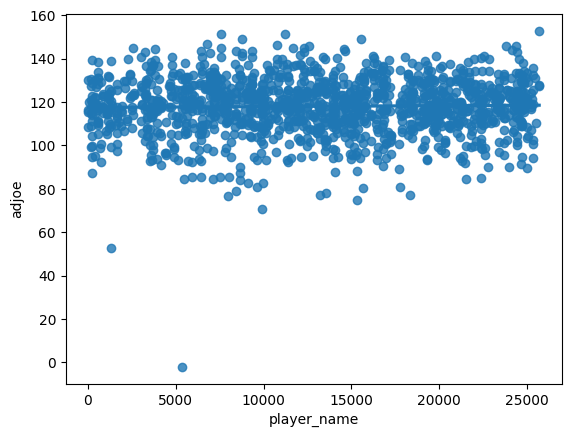

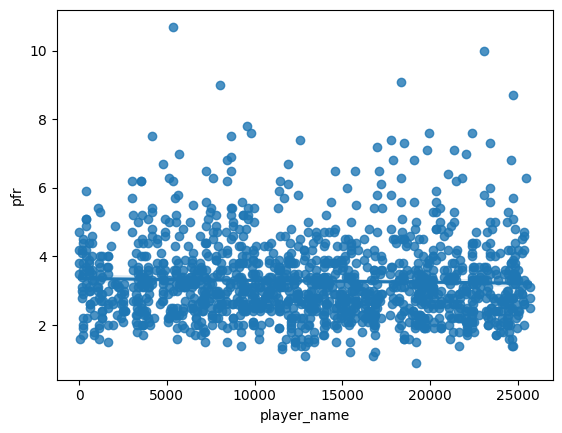

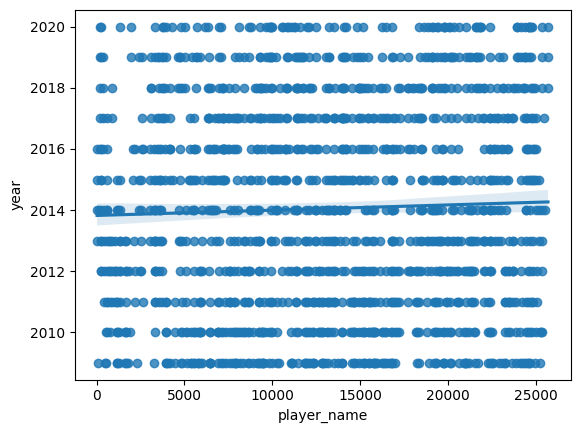

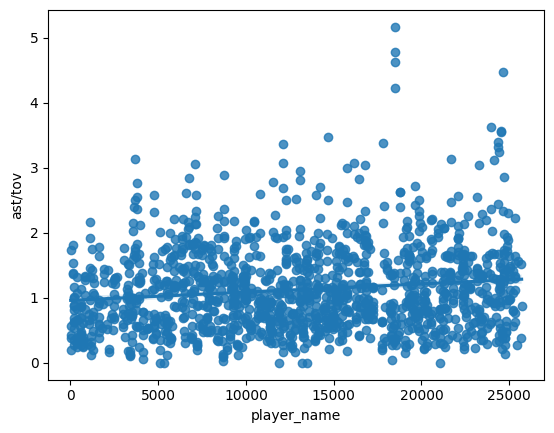

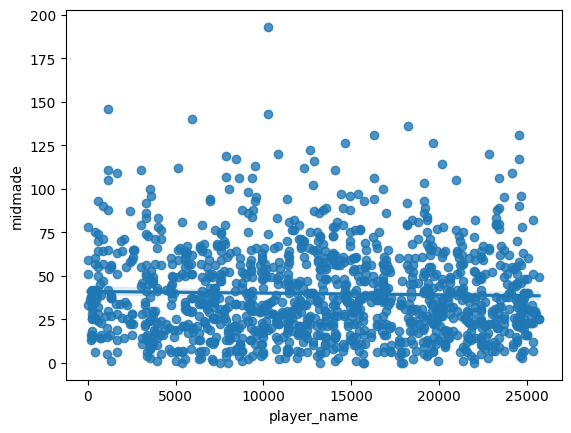

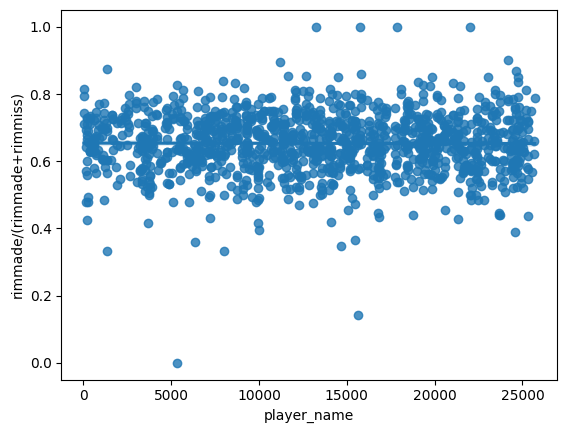

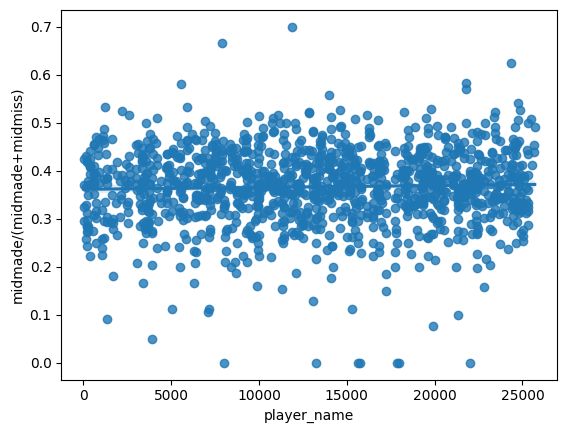

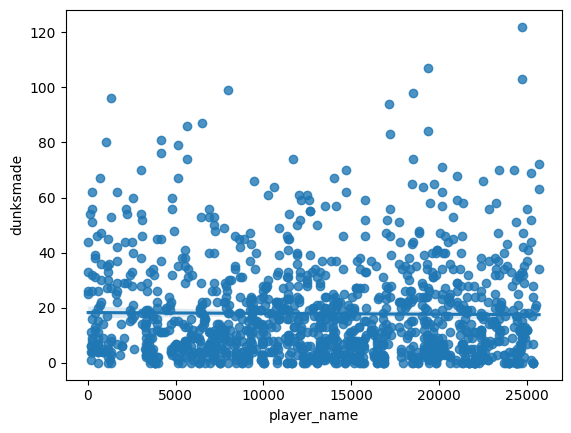

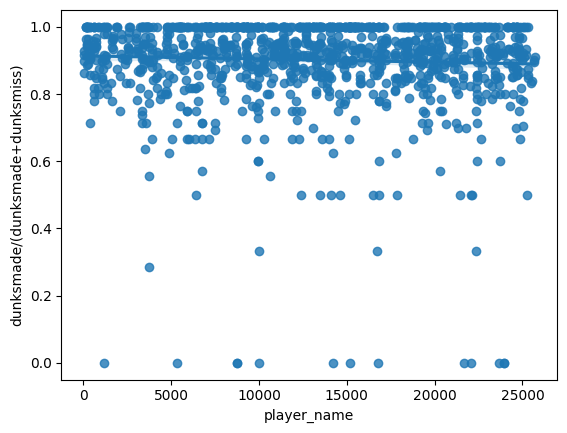

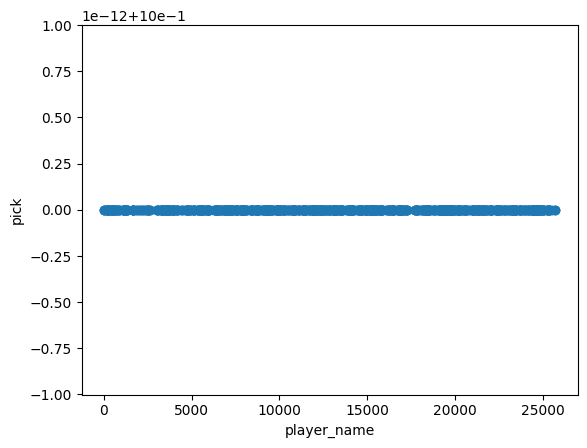

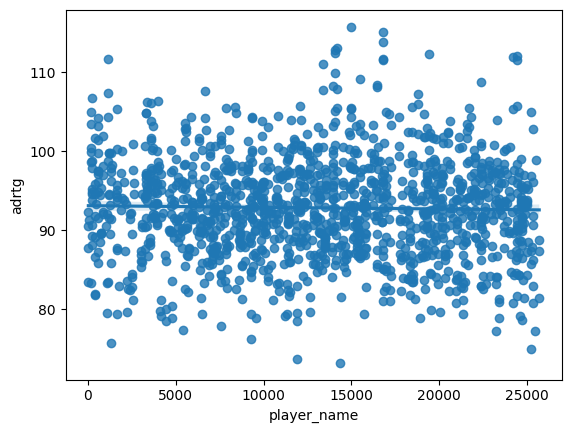

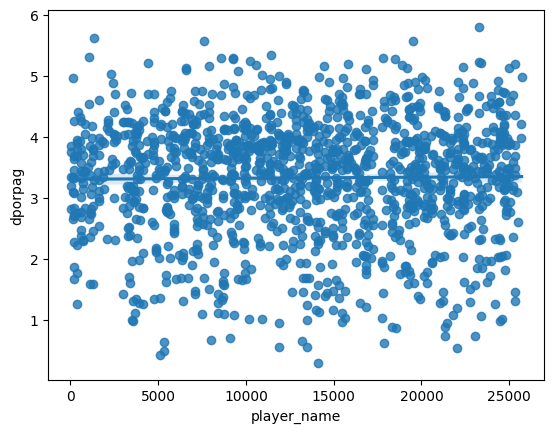

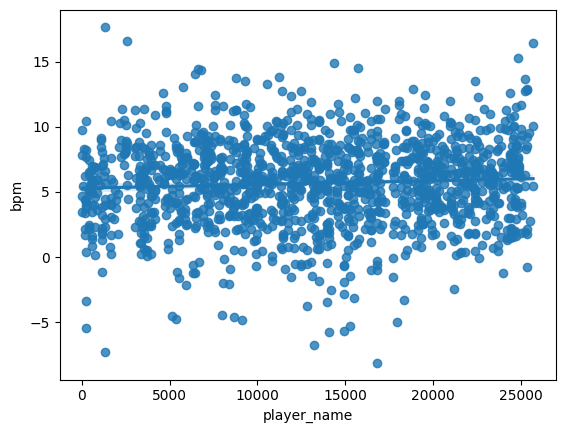

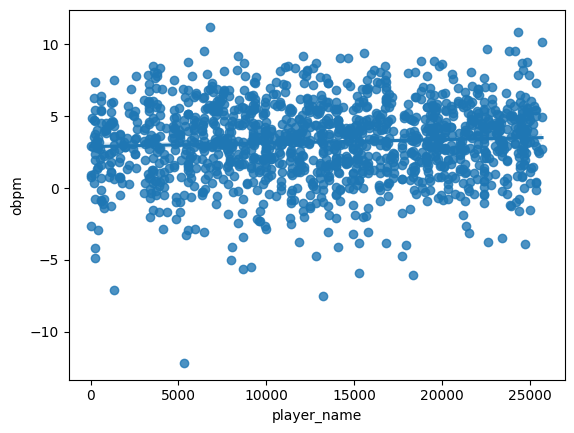

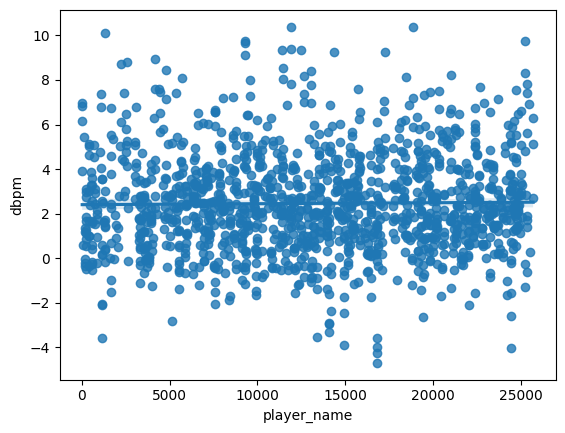

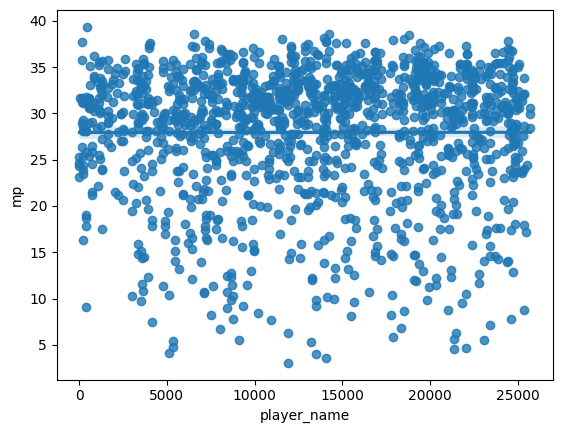

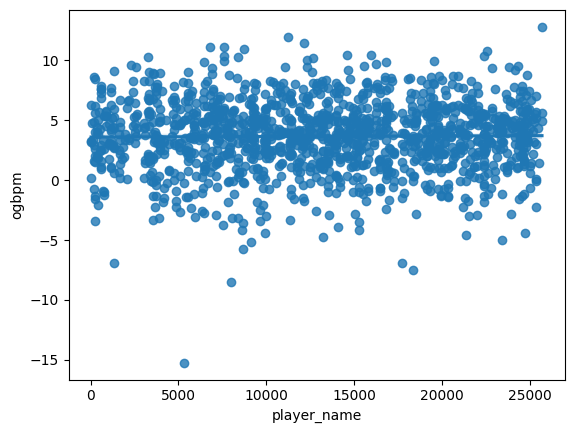

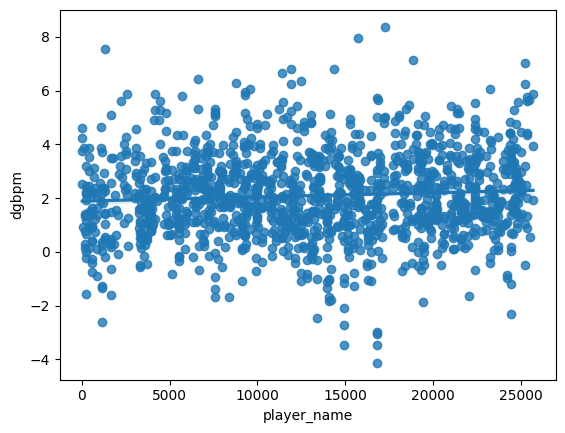

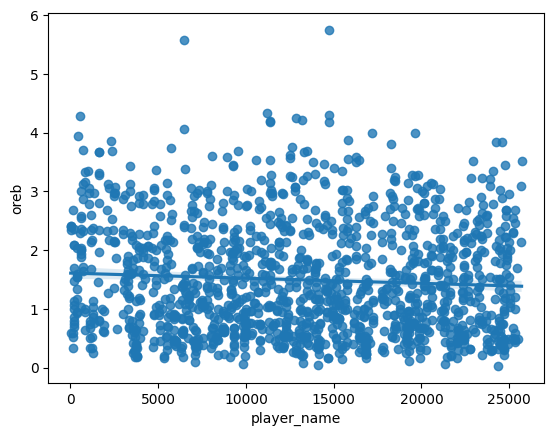

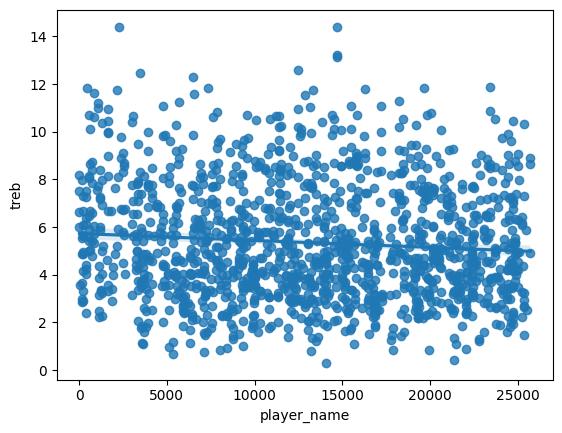

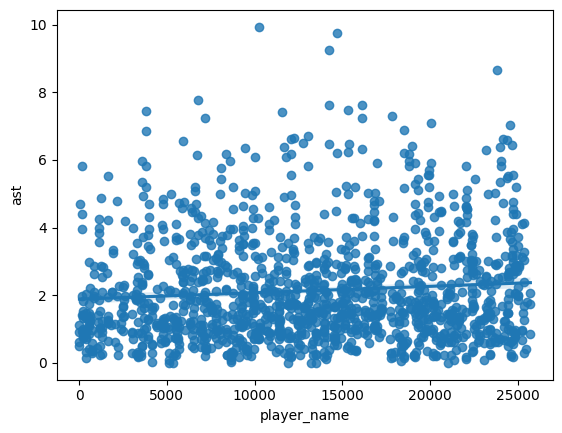

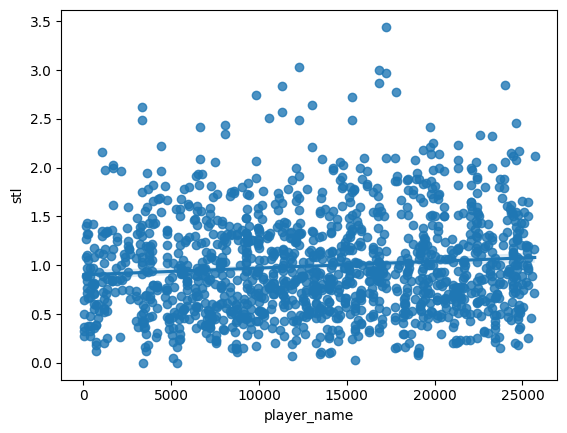

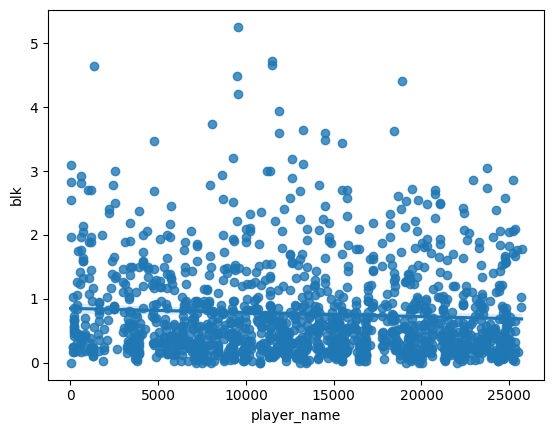

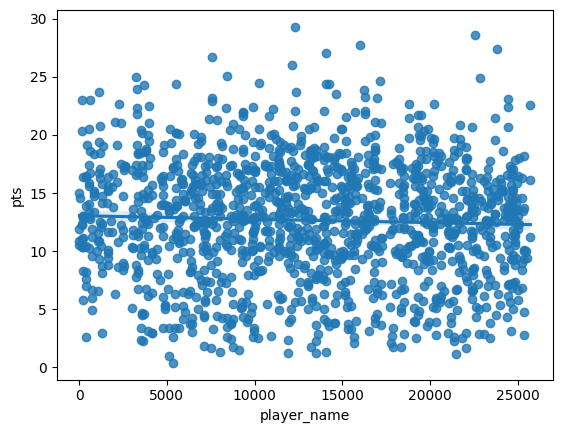

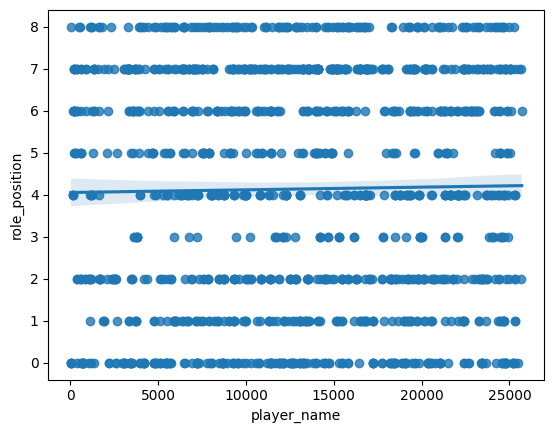

In [ ]:
for j in range(1, len(trainDf.columns)):
    sns.regplot(x=trainDf.columns[0], y=trainDf.columns[j], data=trainDf)
    plt.show()

normalizing the data

## Feature selection 

## Model

In [97]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [99]:
#citations: 
#video: https://aleksandarhaber.com/ensemble-learning-in-scikit-learn-voting-classifiers/
#Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html

#all features (no pick)
features=['usg', 'DRB_per', 'AST_per', 'TO_per', 'twoP_per', 'blk_per', 'porpag', 'rimmade/(rimmade+rimmiss)', 'dunksmade/(dunksmade+dunksmiss)', 'bpm', 'dbpm', 'ogbpm', 'dgbpm']

#trim off features not considered for the training or testing and seperate the pick for predictions 
testNoPick=testDf[features]
testPick=testDf['pick']

#make training and validation sets 
trainNoPick, valNoPick, trainPick, valPick = train_test_split(trainDf[features], trainDf['pick'], test_size=0.2, random_state=42)

#make the 3 models for the ensemble 
logreg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
randFor = RandomForestClassifier(n_estimators=50, random_state=15)
svm = SVC(probability=True, random_state=1) 

# make the voting ensemble classifier 
ensemble = VotingClassifier(estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='hard')

# Fit the voting classifier on the training data
ensemble.fit(trainNoPick, trainPick)

# Predict if player was selected for the draft on the validation set
predVals = ensemble.predict(valNoPick)

# Predict if player was selected for the draft on the test set
predTest = ensemble.predict(testNoPick)


#DONT USE ACCURACY, comparing all 1 and 0 for pick, too many non drafted players, poor metric 
# # Evaluate the accuracy of the ensemble on the validation set
# accuracy = accuracy_score(valPick, predVals)
# print('Ensemble Accuracy on Validation Set:', accuracy)

# # Accuracy for predicting the test data 
# predTest = ensemble.predict(testNoPick)
# testAccuracy = accuracy_score(testPick, predTest)
# print('Ensemble Accuracy on Test Set:', testAccuracy)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

Validation/testing precision, recall and fscore 

In [ ]:
#preformance metrics for validation 
precision = precision_score(valPick, predVals)
recall = recall_score(valPick, predVals)
f1 = f1_score(valPick, predVals)

print('Precision on Validation Set:', precision)
print('Recall on Validation Set:', recall)
print('F1-score on Validation Set:', f1)

#preformance metrics for test 
print()

tPrecision = precision_score(testPick, predTest)
tRecall = recall_score(testPick, predTest)
tF1 = f1_score(testPick, predTest)

print('Precision on Test Set:', tPrecision)
print('Recall on Test Set:', tRecall)
print('F1-score on Test Set:', tF1)


Precision on Validation Set: 0.8846153846153846
Recall on Validation Set: 0.1270718232044199
F1-score on Validation Set: 0.22222222222222224

Precision on Test Set: 0.5555555555555556
Recall on Test Set: 0.10204081632653061
F1-score on Test Set: 0.1724137931034483
